In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import torch

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *
set_plotting_style('default')

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_simple = (band_centers/500)**(-1.2)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")

endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]
M_scatter_simple = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_scatter_simple_smooth = smooth_spectral(M_scatter_simple.T,5).T


/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


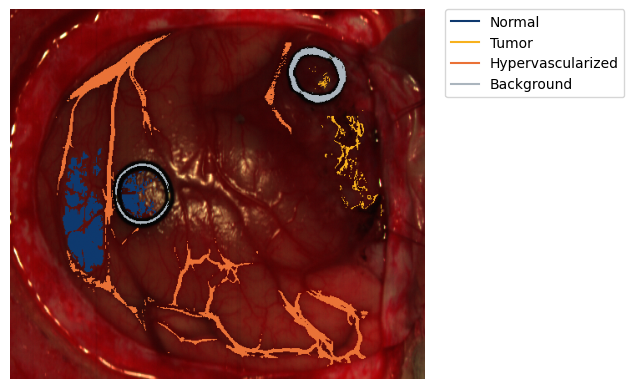

In [3]:
data_folder = "../../datasets/helicoid/012-01"
# data_folder = "../../datasets/helicoid/008-01"

class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")
plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

# preprocessing
img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

In [4]:
def sim_after_proj(absorbance, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    absorbance_proj, _ = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cpu")
    d = similarity(absorbance_proj, endmembers_unmix.squeeze())
    return d

def clip_data(data, lower=1, upper=99):
    lower_clip = np.percentile(data, lower, axis=(0,1), keepdims=True)
    upper_clip = np.percentile(data, upper, axis=(0,1), keepdims=True)
    data = np.clip(data, lower_clip, upper_clip)
    return data

#### Cosine similarity without projection

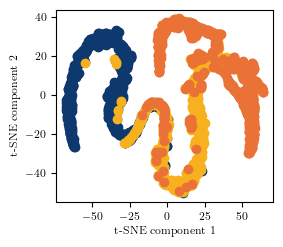

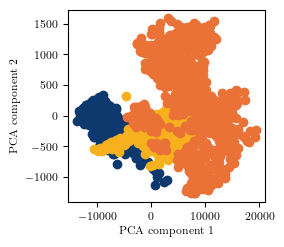

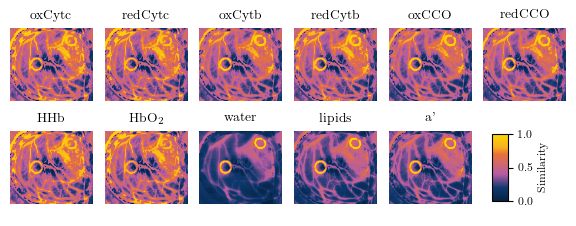

In [5]:
figsize_heatmaps = (5.8,2.3)

n = M_scatter_simple_smooth.shape[1]
data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    data[:,:,i] = similarity(absorbance, M_scatter_simple_smooth[:,i])

plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
plot_pca(data, gt_map, class_labels, mode='equal', figsize=(2.55,2.5), legend_loc=None)
plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=figsize_heatmaps);

### Projection (1st order) + similarity

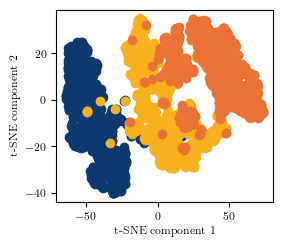

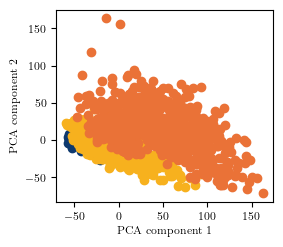

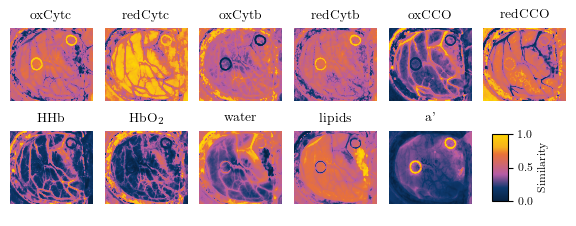

In [6]:
n = M_scatter_simple_smooth.shape[1]
data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    data[:,:,i] = sim_after_proj(absorbance, M_scatter_simple_smooth.T, i)

plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
plot_pca(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=figsize_heatmaps);

Endmember 1 done
Endmember 2 done
Endmember 3 done
Endmember 4 done
Endmember 5 done
Endmember 6 done
Endmember 7 done
Endmember 8 done
Endmember 9 done
Endmember 10 done
Endmember 11 done


(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='t-SNE component 1', ylabel='t-SNE component 2'>)

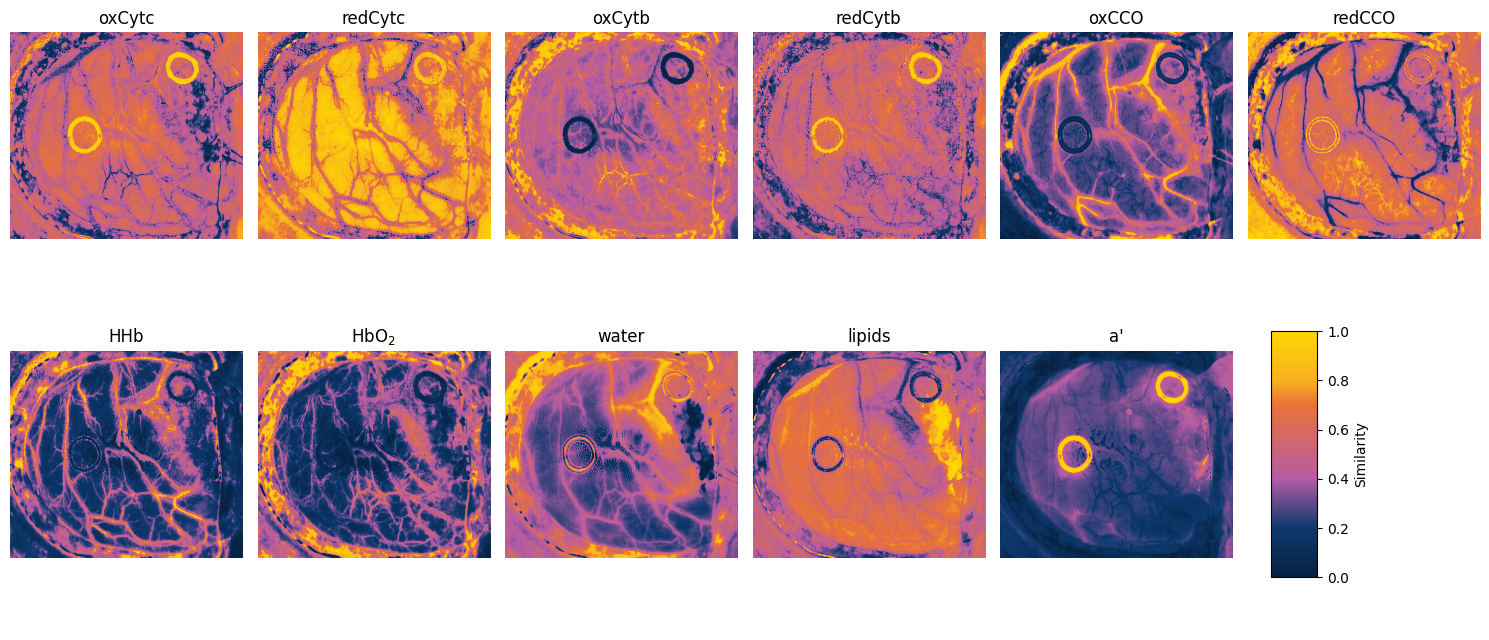

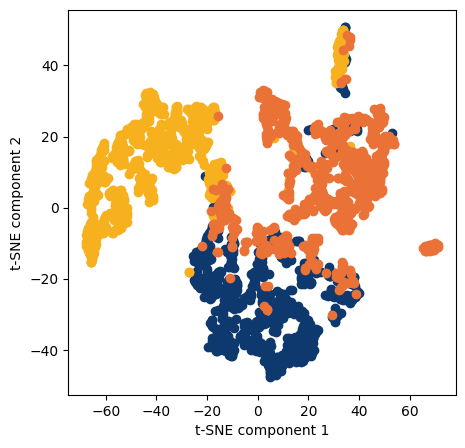

In [5]:
from pysptools.detection.detect import OSP

def osp_2d(spectr, endmember_remove, endmember_target):
    shape = spectr.shape
    spectr = spectr.reshape(-1, shape[-1])
    y = OSP(spectr, endmember_remove, endmember_target)
    return y.reshape(shape[:-1])

n = M_scatter_simple_smooth.shape[1]
data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    endmember_remove = np.delete(M_scatter_simple_smooth.T, i, axis=0)
    endmember_target = M_scatter_simple_smooth.T[i,:]
    data[:,:,i] = osp_2d(absorbance, endmember_remove, endmember_target)
    print(f"Endmember {i+1} done")

plot_concentrations(clip_data(data, 1,99), endmember_labels_scatter, figsize=(15,7));
plot_tsne(clip_data(data, 1,99), gt_map, class_labels, mode='equal', figsize=(5,5), legend_loc=None)

### Projection (2nd order) + similarity

In [7]:
k,n = M_scatter_simple_smooth.shape
extinction_array_bilinear = np.zeros((int(n*(n+1)/2), k))
idx = 0
for i in range(n):
    for j in range(i,n):
        extinction_array_bilinear[idx,:] = M_scatter_simple_smooth[:,i] * M_scatter_simple_smooth[:,j]
        idx += 1

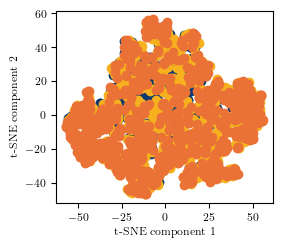

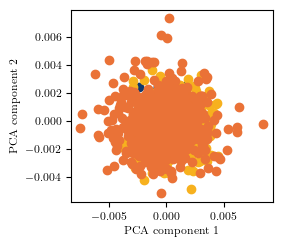

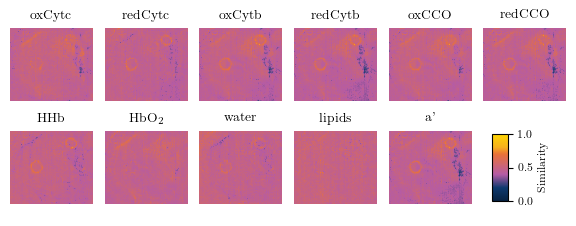

In [8]:
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj=extinction_array_bilinear, endmembers_unmix=M_scatter_simple_smooth.T , device="cpu")

data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    data[:,:,i] = similarity(absorbance_proj, M_scatter_simple_smooth[:,i])

plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
plot_pca(data, gt_map, class_labels, mode='equal', figsize=(2.6,2.5), legend_loc=None)
plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=figsize_heatmaps);

### Projection (1st + 2nd order) + similarity

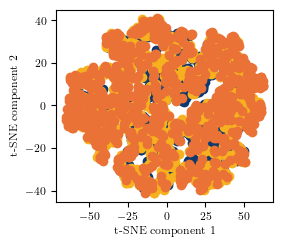

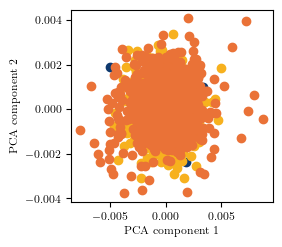

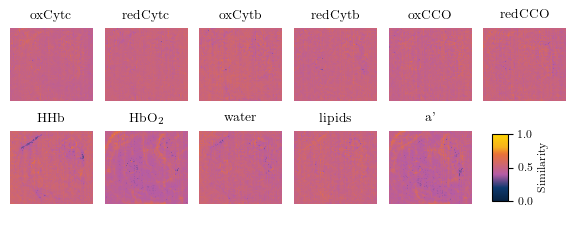

In [9]:
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj=extinction_array_bilinear, endmembers_unmix=M_scatter_simple_smooth.T , device="cpu")

data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    endmembers_curr = endmembers_unmix_proj
    endmembers_curr[i,:] = M_scatter_simple_smooth[:,i]
    data[:,:,i] = sim_after_proj(absorbance_proj, endmembers_curr, i)

plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
plot_pca(data, gt_map, class_labels, mode='equal', figsize=(2.6,2.5), legend_loc=None)
plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=figsize_heatmaps);

#### remove bilinear water components

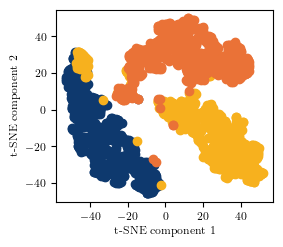

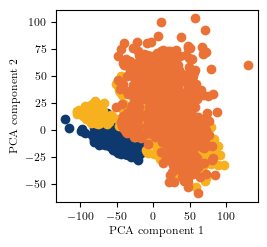

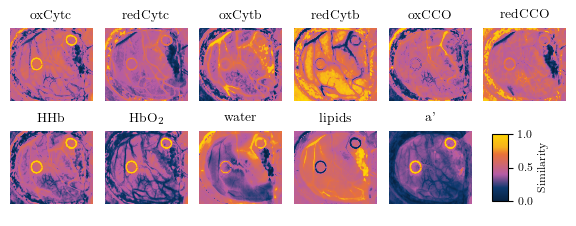

In [10]:
k,n = M_scatter_simple.shape
extinction_array_hb = np.zeros((3, k))
extinction_array_hb[0,:] = smooth_spectral(hb, 5) * smooth_spectral(hb, 5)
extinction_array_hb[1,:] = smooth_spectral(hbo2, 5) * smooth_spectral(hbo2, 5)
extinction_array_hb[2,:] = smooth_spectral(hbo2, 5) * smooth_spectral(hb, 5)

# endmembers_reduced = np.vstack((hb, hbo2, water, scatter_simple))
# endmembers_reduced_smooth = smooth_spectral(endmembers_reduced, 5)
# absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj=extinction_array_hb, endmembers_unmix=endmembers_reduced_smooth , device="cpu")
# data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
# for i in range(4):
#     data[:,:,i] = similarity(absorbance_proj, endmembers_unmix_proj[i,:])


absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj=extinction_array_hb, endmembers_unmix=M_scatter_simple_smooth.T , device="cpu")

data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    endmembers_curr = endmembers_unmix_proj
    endmembers_curr[i,:] = M_scatter_simple_smooth[:,i]
    data[:,:,i] = sim_after_proj(absorbance_proj, endmembers_curr, i)

plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
plot_pca(data, gt_map, class_labels, mode='equal', figsize=(2.6,2.5), legend_loc=None)
plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=figsize_heatmaps);

## Determine scattering powers

In [11]:
def f(b_mie, *args):
    P, abs_proj = args
    scatter_mie = (band_centers/500)**(-b_mie)
    scatter_mie_proj = P @ scatter_mie
    abs_proj = abs_proj / np.linalg.norm(abs_proj) + 1e-8
    similarity = np.dot(scatter_mie_proj, abs_proj) / (np.linalg.norm(scatter_mie_proj) + 1e-8)
    # |a-b|^2 = a^Ta + b^Tb - 2a^Tb = 2 - 2a^Tb = 2 - 2*similarity for normalized vectors a and b
    d = 2 - 2*similarity
    return d

def d_f(b_mie, *args):
    P, abs_proj = args
    scatter_mie = (band_centers/500)**(-b_mie)
    scatter_mie_norm = np.linalg.norm(scatter_mie)
    abs_proj = abs_proj / np.linalg.norm(abs_proj) + 1e-8
    d_d = -2
    d_similarity = abs_proj/scatter_mie_norm - scatter_mie * np.dot(abs_proj, scatter_mie) / (scatter_mie_norm**3)
    d_scatter_mie_proj = P
    d_scatter_mie = - np.log(band_centers/500) * scatter_mie
    return d_d * d_similarity.T @ d_scatter_mie_proj @ d_scatter_mie

def optimize_scatter_ls(P, abs_proj, x0):
    result = np.zeros_like(abs_proj[:,:,0])
    for i in tqdm(range(abs_proj.shape[0])):
        for j in range(abs_proj.shape[1]):
            x0 = 0.6
            bounds = (0, 4)
            args = (P, abs_proj[i, j, :])
            result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
    return result     

#### Mie scattering

In [15]:
# scatter_rayleigh = (band_centers/500)**(-4)
# M_scatter_rayleigh = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_rayleigh)).T
# M_scatter_rayleigh_smooth = smooth_spectral(M_scatter_rayleigh.T,5).T

# abs_proj_scatter, _ = project_absorbance(absorbance, M_scatter_rayleigh_smooth.T, M_scatter_rayleigh_smooth.T)
# P_scatter = np.eye(M_scatter_rayleigh_smooth.shape[0]) - M_scatter_rayleigh_smooth @ np.linalg.pinv(M_scatter_rayleigh_smooth)
# b_mie_img = optimize_scatter_ls(P_scatter, abs_proj_scatter, x0=0.6)

# np.savetxt("b_mie_img.txt", b_mie_img)

b_mie_img = np.loadtxt("b_mie_img.txt")

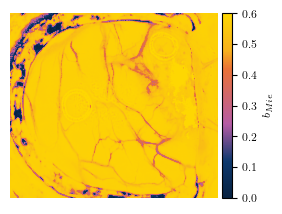

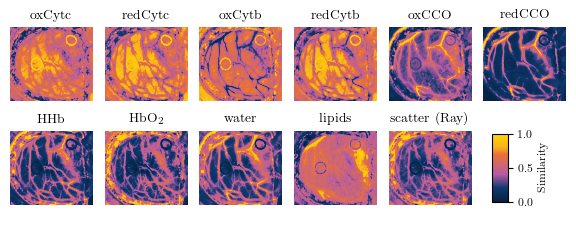

In [36]:
fig, ax = plt.subplots(1,1, figsize=(2.87,3))
ax.imshow(b_mie_img, cmap=tum_cmap)
ax.axis("off")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(ax.images[0], cax=cax)
cbar.set_label("$b_{Mie}$")

# load npy file
c_after_mie_proj = np.load("c_after_mie_proj.npy")
endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "scatter (Ray)"] 
plot_concentrations(clip_data(c_after_mie_proj), endmember_labels_scatter, figsize=figsize_heatmaps);

#### Simple scattering

In [22]:
# M = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T
# M_smooth = smooth_spectral(M_scatter_rayleigh.T,5).T

# abs_proj_scatter, _ = project_absorbance(absorbance, M_smooth.T, M_smooth.T)
# P_scatter = np.eye(M_smooth.shape[0]) - M_smooth @ np.linalg.pinv(M_smooth)
# b_mie_img = optimize_scatter_ls(P_scatter, abs_proj_scatter, x0=1.2)

# np.savetxt("b_simple_img.txt", b_mie_img)

b_simple_img = np.loadtxt("b_simple_img.txt")

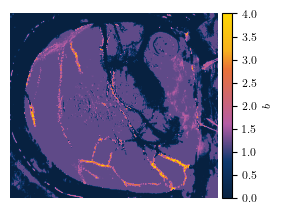

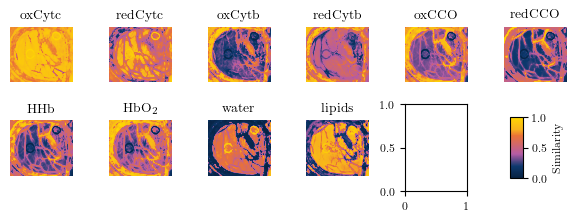

In [37]:
fig, ax = plt.subplots(1,1, figsize=(2.87,3))
ax.imshow(b_simple_img, cmap=tum_cmap)
ax.axis("off")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(ax.images[0], cax=cax)
cbar.set_label("$b$")

# load npy file
c_after_simple_proj = np.load("c_after_simple_proj.npy")
endmember_labels = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids"]
plot_concentrations(clip_data(c_after_simple_proj), endmember_labels, figsize=figsize_heatmaps);